In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

In [19]:
best_X = pd.read_pickle('best_X.pkl')
scaled_y = pd.read_pickle('scaled_y.pk4')

#### Using best_X (best features)

c:\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'min_samples_leaf': 5, 'min_samples_split': 5}
GridSearchSV Score: 0.9148936170212766
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97        46
         1.0       0.75      0.88      0.81        60
         2.0       0.88      0.82      0.85        65
         3.0       0.86      0.79      0.82        53
         4.0       0.95      0.97      0.96        63
         5.0       1.00      0.96      0.98        69
         6.0       0.99      1.00      0.99        67

    accuracy                           0.91       423
   macro avg       0.91      0.91      0.91       423
weighted avg       0.92      0.91      0.91       423

Accuracy:  0.9125295508274232


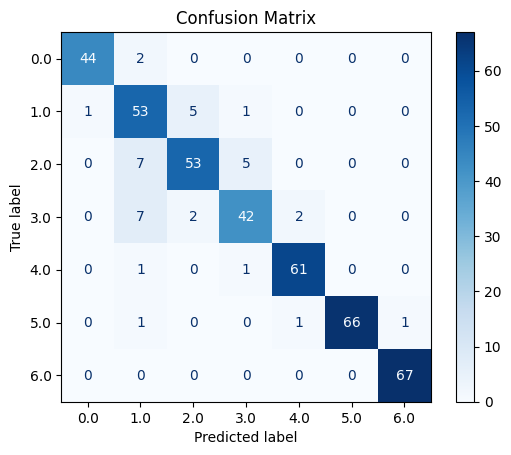

In [25]:
X_train, X_test, y_train, y_test = train_test_split(best_X, scaled_y, test_size = 0.2, random_state=1234)

# hyperparameter tuning with GridSearchCv
params = {'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [5, 10, 15]
          }

grid = GridSearchCV(RandomForestClassifier(), params, cv=10, scoring='accuracy', return_train_score=False)
grid = grid.fit(X_train, np.ravel(y_train))

print(grid.best_params_)
print('GridSearchSV Score:', grid.score(X_test, y_test))

# plug in the best hyperparameters determined above
rf_dt_best = RandomForestClassifier(min_samples_leaf=5, min_samples_split=5)

rf_dt_best = rf_dt_best.fit(X_train, np.ravel(y_train))

y_pred = rf_dt_best.predict(X_test)
y_pred_probas = rf_dt_best.predict_proba(X_test)

print(classification_report(y_test, y_pred)) # assumes 0.5 threshold as default
print('Accuracy: ', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_dt_best.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

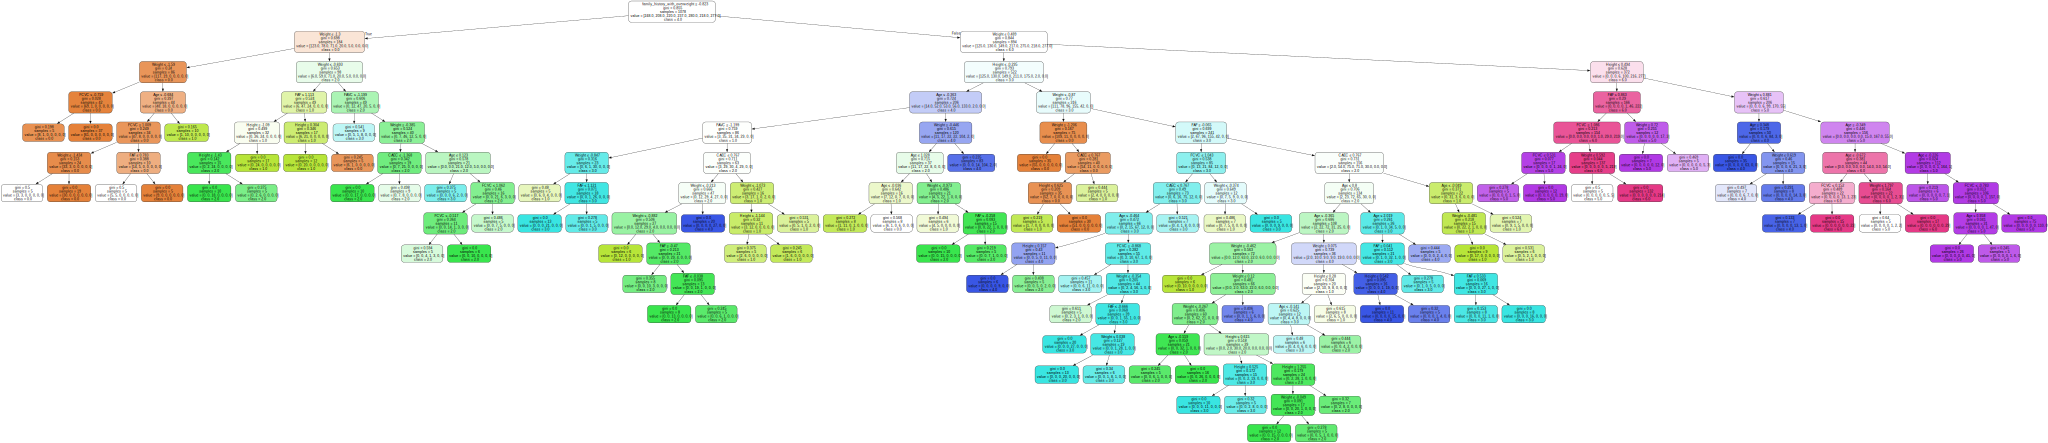

In [26]:
# visualize tree

estimator = rf_dt_best.estimators_[0]  # Pick the first tree

dot_data = export_graphviz(
    estimator,
    out_file=None,
    feature_names=list(X_train.columns),
    class_names=[str(c) for c in rf_dt_best.classes_],
    filled=True, rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

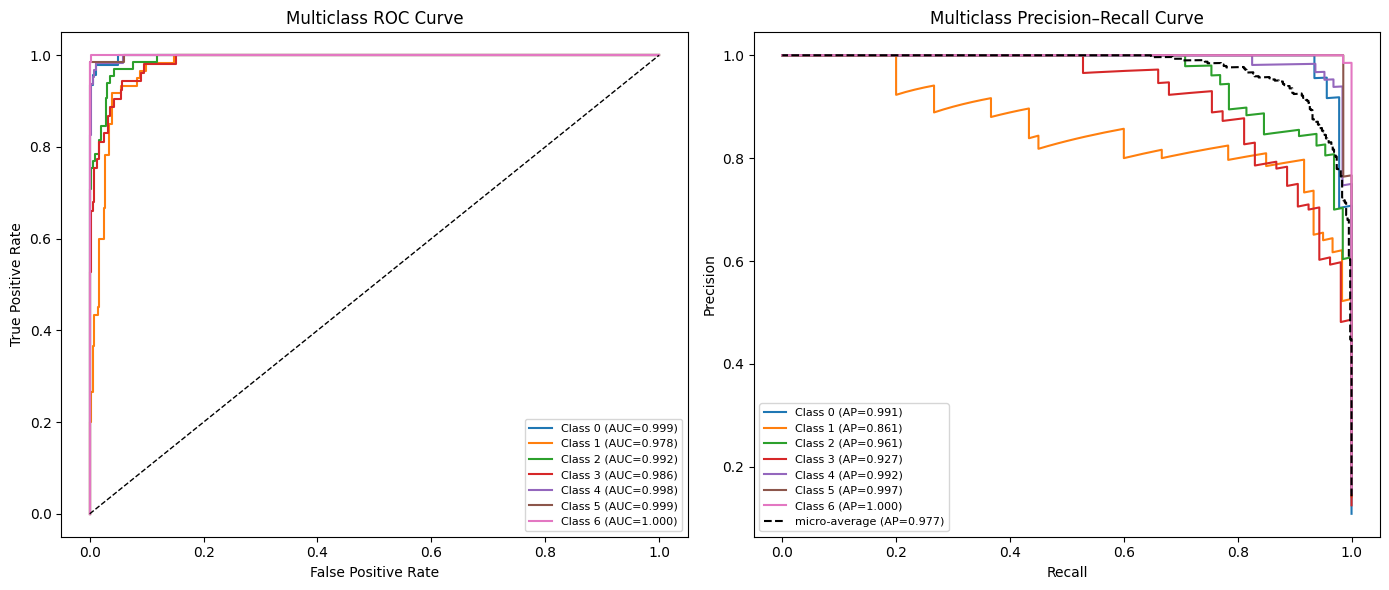

In [27]:
# ROC curve code and Precision-Recall code was gathered from online sources. 
# We had to do this because traditional ROC curves and Prec-Recall curves work for binary outcomes but our problem is multilcass.

# get y data ready by using label_binarize
y_pred_probas = rf_dt_best.predict_proba(X_test)
y_true = np.array(y_test, dtype=int)
classes = list(range(y_pred_probas.shape[1]))
y_bin = label_binarize(y_true, classes=classes)

plt.figure(figsize=(14, 6))

# --- ROC Curve ---
plt.subplot(1, 2, 1)
for i in range(y_bin.shape[1]):  # calculate and plot roc curve for each classification in target attribute
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_probas[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label=f"Class {classes[i]} (AUC={roc_auc:.3f})")

# roc curve plotting info
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(fontsize=8)


# --- Precision-Recall Curve --- 
plt.subplot(1, 2, 2)
for i in range(y_bin.shape[1]):  # calculate and plot prec-recall curve for each classification in target attribute
    prec, rec, _ = precision_recall_curve(y_bin[:, i], y_pred_probas[:, i])
    avg_prec = average_precision_score(y_bin[:, i], y_pred_probas[:, i])
    plt.plot(rec, prec, lw=1.5, label=f"Class {classes[i]} (AP={avg_prec:.3f})")

# aggregates all classes (dotted line)
precision_micro, recall_micro, _ = precision_recall_curve(y_bin.ravel(), y_pred_probas.ravel())
avg_prec_micro = average_precision_score(y_bin, y_pred_probas, average="micro")
plt.plot(recall_micro, precision_micro, color="black", linestyle="--",
         label=f"micro-average (AP={avg_prec_micro:.3f})", lw=1.5)

# prec-recall curve plotting info
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass Precision–Recall Curve")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()